# 

How would normalization affect the transition matrix?

In [0]:
using DrWatson
using CurrentSheetTestParticle
using CurrentSheetTestParticle: inverse_v
using TestParticleAnalysis
using Beforerr
includet("../src/utils.jl")
includet("../src/plot.jl")
tmax = CurrentSheetTestParticle.DEFAULT_TSPAN[2]
save_everystep = false
verbose = false
dtmax = 1e-1
diffeq = (; save_everystep, verbose, dtmax)

In [0]:
p = RDProblemParams(
    θ=85, β=45, v=64.0, init_kwargs=(; Nw=256, Nϕ=256)
    # θ=85, β=45, v=64.0, init_kwargs=(; Nw=16, Nϕ=16)
)
sols, (wϕs, B) = solve_params(p; diffeq...);
results = process_sols(p, sols, wϕs)
results.iter .= 1

In [0]:
function iterate_results(results; iter=3)
    results_i = [results]
    for i in range(1, iter)
        old_u0s = results_i[i].u1
        new_u0s = map(old_u0s) do u0
            [u0[1:2]..., -u0[3], u0[4:6]...]
        end
        sols = solve_params(B, new_u0s; diffeq...)
        results = process_sols(sols, B, wϕs)
        results.iter .= i + 1
        push!(results_i, results)
    end
    vcat(results_i...)
end

## Distribution

In [0]:
using DataFramesMeta

function process_results_gryo!(df)
    @chain df begin
        @rtransform!(:ψ1 = inverse_v(:u1, :B)[3])
        @transform!(:Δψ = rem2pi.(:ψ1 - :ϕ0, RoundDown))
    end
end

@chain results begin
    process_results_gryo!
end

In [0]:
w_bins = range(-1, 1, length=129)
α_bins = range(0, 180, length=129)
sinα_bins = range(0, 1, length=63)

f = Figure(; size=(1200, 600))
l = data(results) * mapping(row=AlgebraOfGraphics.dims(1) => renamer(["Initial", "Final"]), col=:iter => nonnumeric)
normalization = :probability
draw!(f[1, 1], l * mapping([w0, w1] .=> "cos(α)") * histogram(; bins=w_bins, normalization))
draw!(f[1, 2], l * mapping([α0, α1] .=> "α") * histogram(; bins=α_bins, normalization))
draw!(f[1, 3], l * mapping([:s2α0, :s2α1] .=> "sin(α)^2") * histogram(; bins=sinα_bins, normalization))
f

In [0]:
ψ_bins = range(0, 2π, length=32)

draw(l * mapping([ϕ0, :ψ1] .=> "ψ"; layout=leave) * histogram(; bins=ψ_bins))

draw(data(results) * mapping(:Δψ; layout=leave) * histogram())

## Transition matrix

In [0]:
include("../src/tm.jl")
weights = 1 ./ results.t1
tm = transition_matrix_w(results)
tm_w = transition_matrix_w(results; weights)

In [0]:
let i = 5, lowclip = 1e-5, colorscale = log10, colorrange = (lowclip, 10)
    kw = (; colorscale, colorrange)
    f = Figure()

    tmi = tm^i
    @show sum(tmi; dims=2)
    @show sum(tmi; dims=1)

    plot!(Axis(f[1, 1]), tm; kw...)
    plot!(Axis(f[2, 1]), tmi; kw...)
    plot!(Axis(f[1, 2]), tm_w; kw...)
    plot!(Axis(f[2, 2]), tm_w^i; kw...)
    easy_save("tm/tm_weighted")
end

In [0]:
let i = 16, df = results, binedge = range(0, 1, length=64)
    kw = (;)
    binedges = (binedge, binedge)
    h = Hist2D((df.s2α0, df.s2α1); binedges)
    tm = transition_matrix(h)
    tmi = tm^i
    f = Figure()
    plot!(Axis(f[1, 1]), tm; kw...)
    plot!(Axis(f[2, 1]), tmi; kw...)
    @info sum(tmi; dims=1)
    @info sum(tmi; dims=2)
    f
end

In [0]:
ψ_scale() = scales(Color=(; colormap=:brocO))

let df = results, xy = (w0, ϕ0), figure = (; size=(1200, 600))
    f = Figure(; figure...)

    spec = data(results) * mapping(xyw...) * density_layer()
    cdraw!(f[1, 1], spec, tm_scale(); axis=w_axis)

    gl = f[1, 2]
    l = data(df) * mapping(xy...)
    cdraw!(gl[1, 1], l * (; color=Δw))
    cdraw!(gl[2, 1], l * (; color=Δt))
    cdraw!(gl[3, 1], l * (; color=:ψ1,), ψ_scale(); colorbar=(; colormap=(:brocO)))
    # cdraw!(gl[3, 1], l * (; color=(:Δw, :t1) => (x, y) -> x / y))

    easy_save("tm/Δw_Δt")
end

### Averaging

In [0]:
using StatsBase
results_avg = combine(groupby(results, :w0), :Δψ => mean, :Δw => mean; renamecols=false)
sort!(results_avg, :w0)
results_avg.Δw_cumsum .= cumsum(results_avg.Δw)

r = renamer(["<Δψ>", "<Δ cos α>", "<Δ cos α> cumsum"])
ys = [:Δψ, :Δw,]
draw(data(results_avg) * mapping(w0, ys; color=dims(1) => r) * visual(Scatter))

## Cumulative distribution

In [0]:
using CairoMakie
using JumpProcessesPDF

In [0]:
s2α_jumps = df_rand_jumps(results, :s2α0, :Δs2α; n=100, incremental=true, bounds=(0, 1))
μ_jumps = df_rand_jumps(results, :μ0, :Δμ; n=100, incremental=true, bounds=(-1, 1))

let position = :rb,
    mid_index = div(size(s2α_jumps, 1), 2)

    f = Figure(;)
    ax = Axis(f[1, 1]; xlabel="sin(α)^2", ylabel="F")
    ecdfplot!(s2α_jumps[1, :]; label="Initial")
    ecdfplot!(s2α_jumps[mid_index, :]; label="Intermediate", color=Cycled(2))
    ecdfplot!(s2α_jumps[end, :]; label="Final", color=Cycled(3))

    Axis(f[1, 2]; xlabel="cos(α)")
    ecdfplot!(μ_jumps[1, :]; label="Initial")
    ecdfplot!(μ_jumps[mid_index, :]; label="Intermediate", color=Cycled(2))
    ecdfplot!(μ_jumps[end, :]; label="Final", color=Cycled(3))

    Legend(f[0, 1:end], ax; tellheight=true, orientation=:horizontal)
    easy_save("pa_cdf")
end

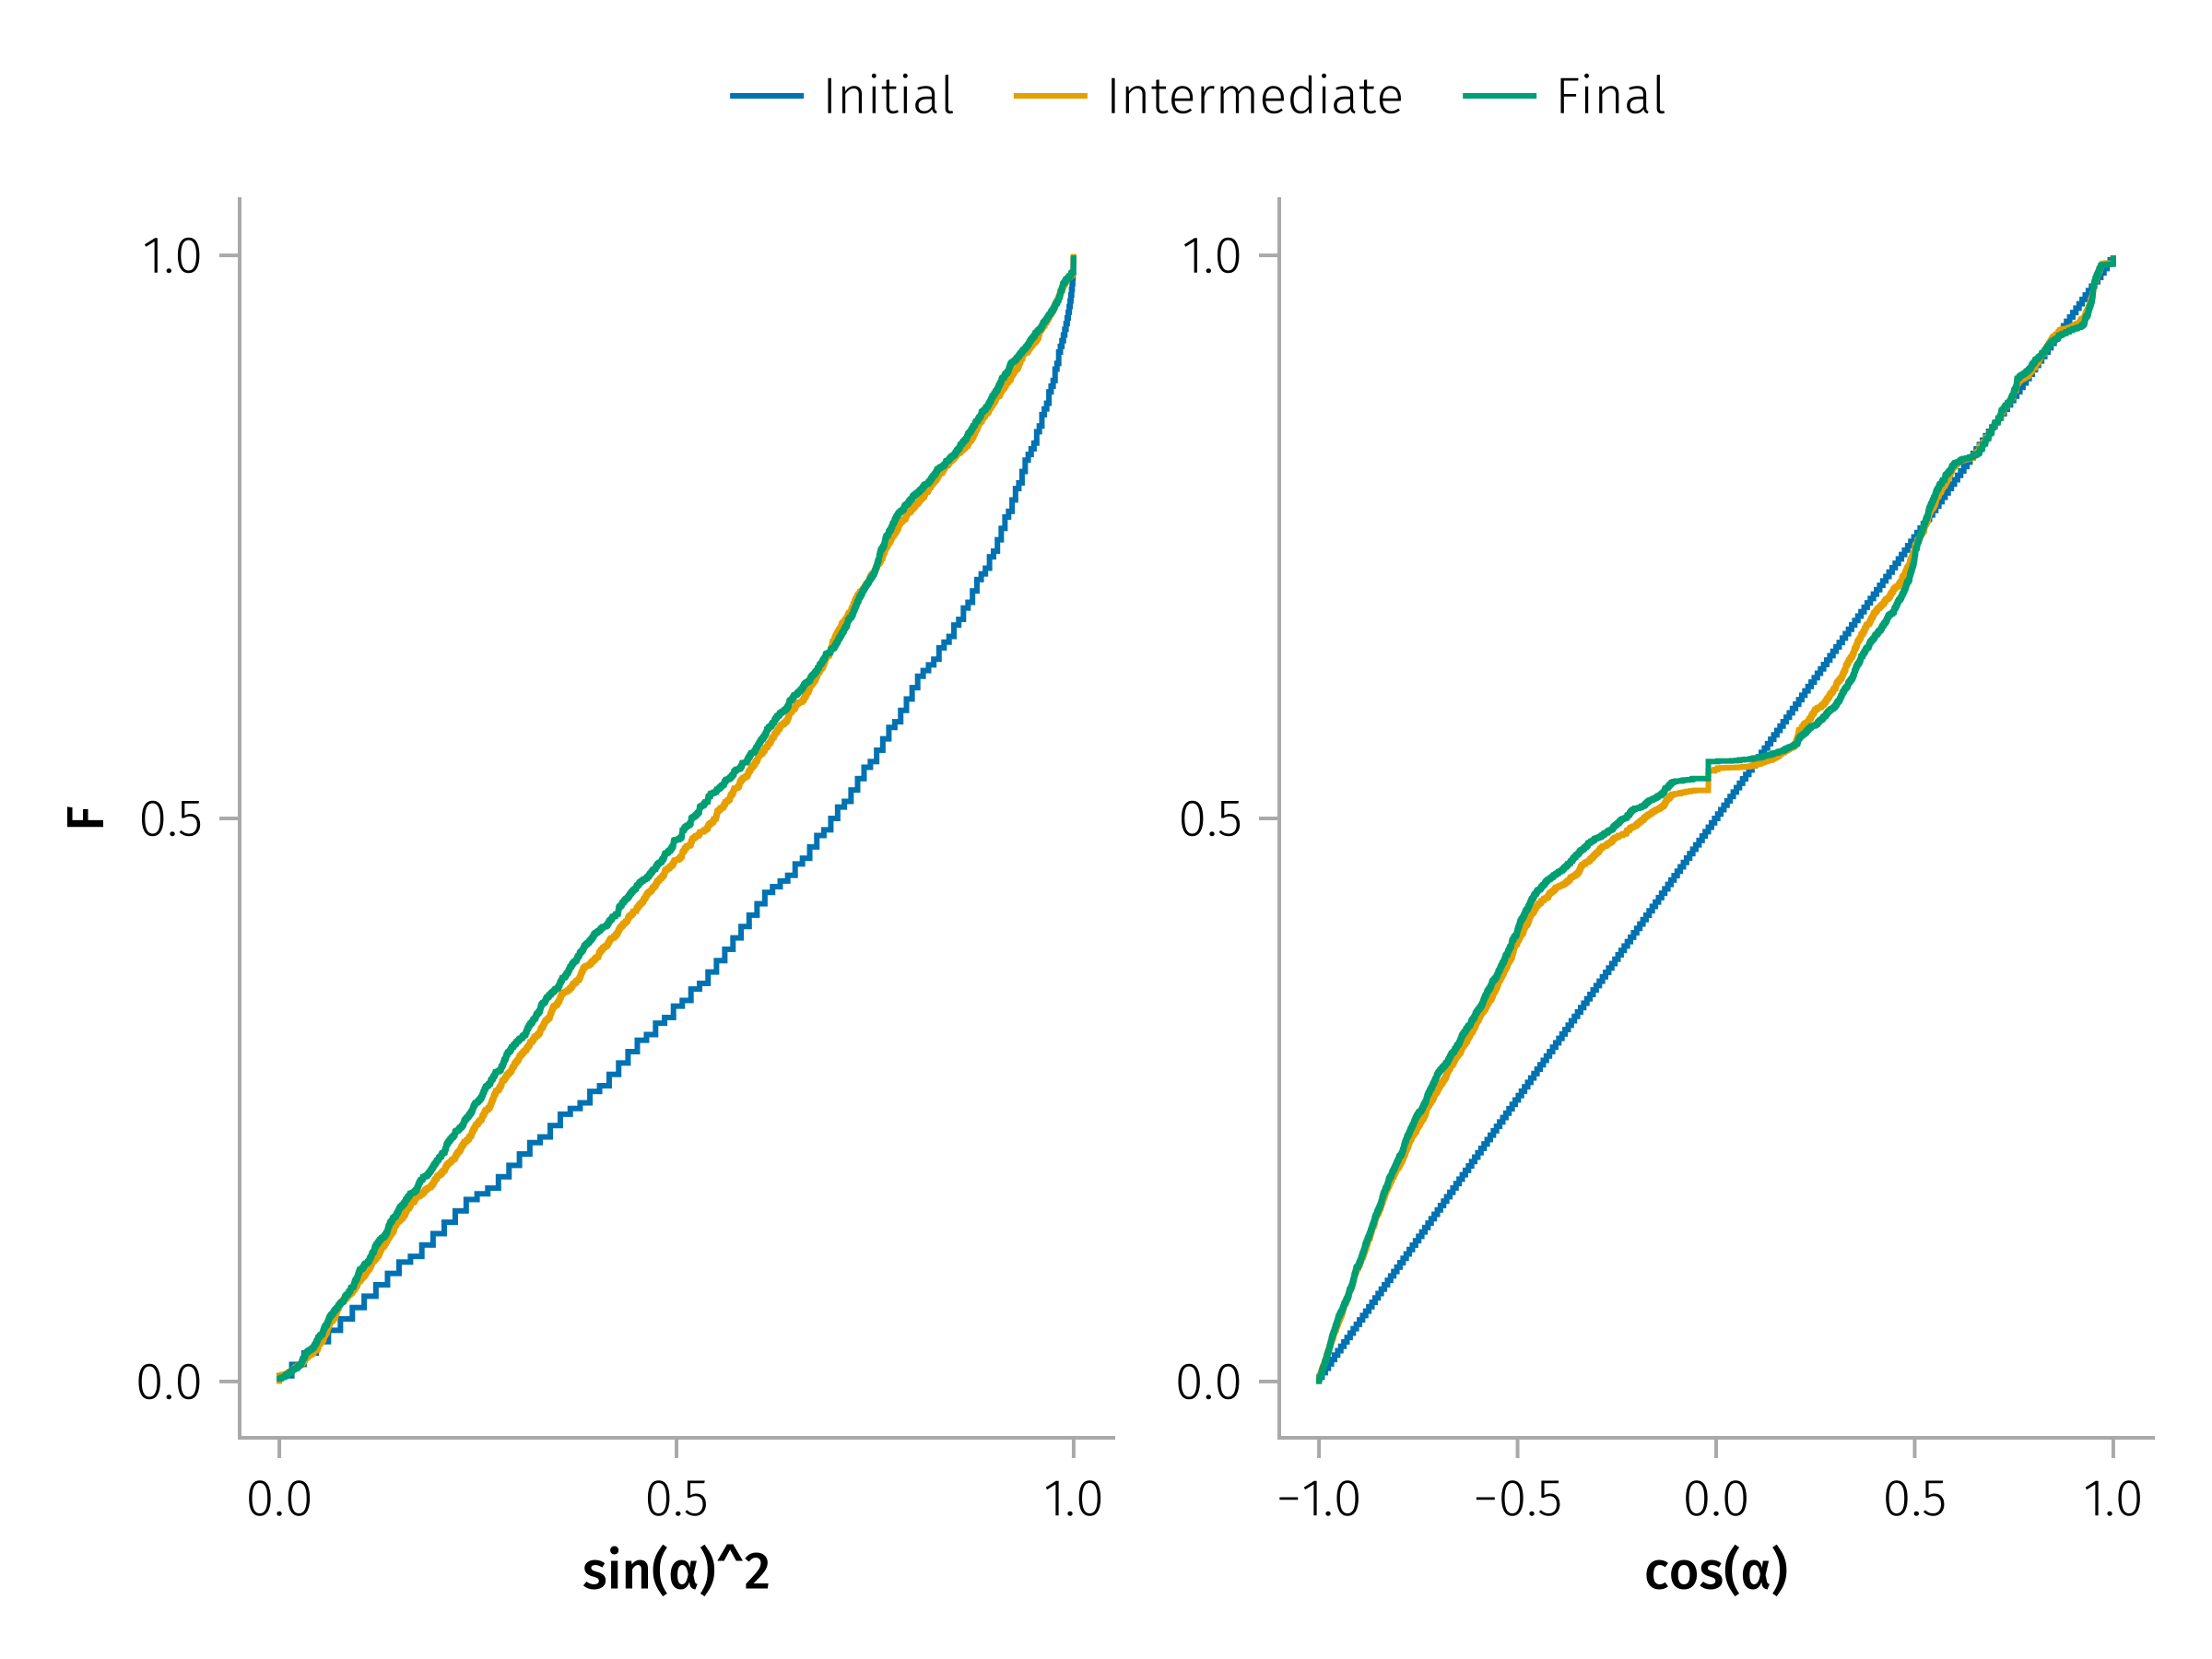

In [0]:
# calculate the moments of the distribution
let jumps = s2α_jumps
    diffs = jumps .- jumps[1, :]'
    m1 = mean(diffs, dims=2)
    m2 = mean(diffs .^ 2, dims=2) - m1 .^ 2
    scatterlines(vec(m2))
end